# Exploring & Testing Use of NURBS in DIC
## Sam Potter
## Current: 12/7/18

## Path and Imports

In [1]:
# bootstrap $PATH
import sys
import os
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
import warnings
from dic import nurbs
from dic import fileIO
from dic import numerics
from dic import analysis
from dic import image_processing
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as sciopt

## Magics

In [2]:
%matplotlib inline

### Read in ref image file

In [3]:
# Read
# Hard code absolute paths for now. Fix later'
# dic_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
# psfdi_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DOA_cropped_gray_pad_0.tiff'
dic_name = '/workspace/stpotter/git/bitbucket/dic/data/DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = '/workspace/stpotter/git/bitbucket/dic/data/DOSA_cropped_gray_pad_0.tiff'
ref_image = cv2.imread(dic_name, -1)  # Read in image 'as is'
ref_image = ref_image.astype('uint8')

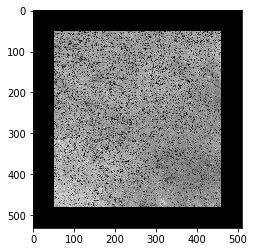

In [4]:
# Display
plt.imshow(ref_image, cmap='gray')

## Deform Ref Image

In [5]:
# Translate image in x
transx = np.array([[1.0, 0.0, 25.0],
                   [0.0, 1.0, 0.0]])
def_image = image_processing.im_warp(ref_image, transx)

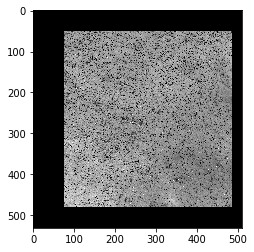

In [6]:
# Display
plt.imshow(def_image, cmap='gray')

## Let user grab region of interest

### Actually, this doesn't seem to be playing well with the Notebook.

### For now, just going to get the contour (since it's a padded image) and go from there

In [7]:
# For now, this is just a rectangle. More complicated shapes could be used, but that's for later
# r = cv2.selectROI(ref_image)

## Grab contour edges of padded reference image

### Okay, this isn't working either. Some issue with incorrect data type. Puzzler though as images are unit8 as seems to be required.

### Manually specify node locations for now

In [8]:
# Threshold the image first
# retval, ref_threshold = cv2.threshold(ref_image, 5, 255, cv2.THRESH_BINARY)  # Read docs for more detail

In [9]:
# plt.imshow(ref_threshold, cmap='binary')

In [10]:
# Get the contours
# Read docs for more details
# ref_contour_im, ref_contour, ref_heirarch = cv2.findContours(ref_threshold.copy(), cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE)

## Manually Specify Region of Interest

In [11]:
# Format: [colum index for start of X, column index for end of X, row index for start of Y, row index for end of Y]
subregion_indices = [100, 400, 100, 400]

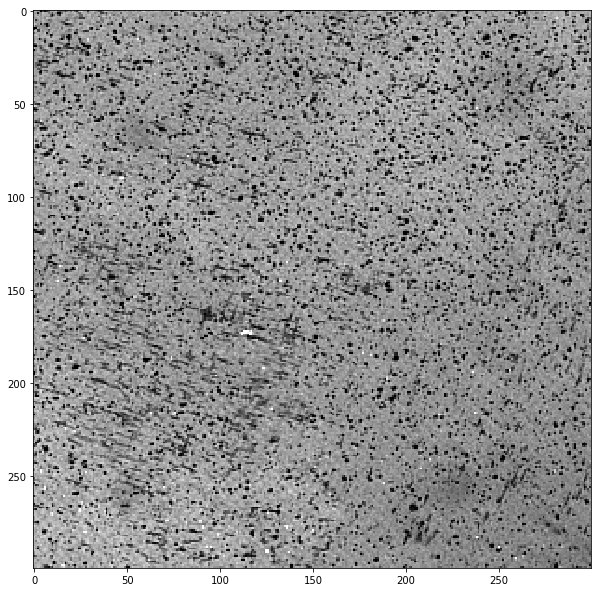

In [12]:
# Extract these regions from ref image and plot
ref_subimage = ref_image[subregion_indices[2]:subregion_indices[3], subregion_indices[0]:subregion_indices[1]]
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(ref_subimage, cmap='gray')
plt.show()

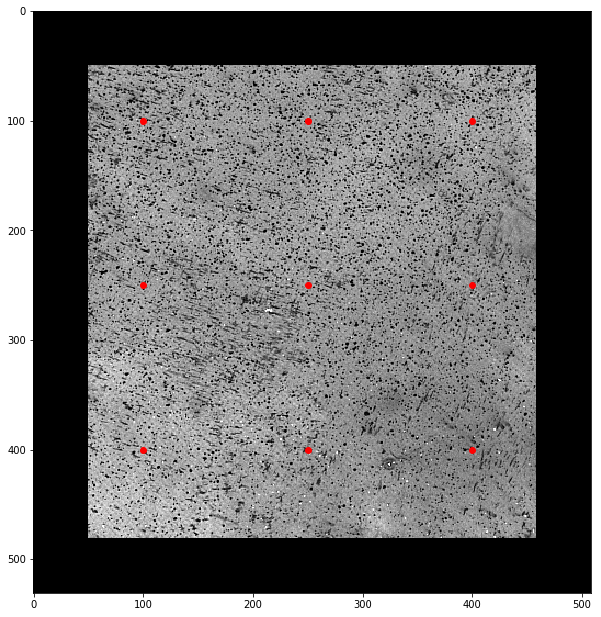

In [13]:
# Plot the mesh nodes on the original image
# Would be nice to be able to visualize full mesh
x_coord = np.array([subregion_indices[0], subregion_indices[1], np.mean((subregion_indices[0], subregion_indices[1]))])
y_coord = np.array([subregion_indices[2], subregion_indices[3], np.mean((subregion_indices[2], subregion_indices[3]))])
x, y = np.meshgrid(x_coord, y_coord)
nodex = x
nodey = y
nodes = np.column_stack((nodex.flatten(), y.flatten()))
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(ref_image, cmap='gray')
ax.plot(x, y, 'o', color='red')
plt.show()

## Playing with image interpolation

In [14]:
# get bspline coefficients (wrapping scipy for now as future functionality planned)
ref_coeffs = numerics.image_interp(ref_image)
def_coeffs = numerics.image_interp(def_image)

## Correlation Functions 

## Wrap this minfun in scipy optimization library

### So this isn't really working either. Will need to figure out how to interpolate image

In [15]:
args = (nodes, ref_image, transx_im)
x0 = [24, 0]
foo = sciopt.OptimizeResult
result = sciopt.minimize(analysis.minfun, x0, args=args, method='Powell', options={'disp':True})

NameError: name 'transx_im' is not defined

In [ ]:
result.x.astype('int')

In [ ]:
xcoord_new = x_coord + result.x.astype('int')[0] * np.ones(len(x_coord))
ycoord_new = y_coord + result.x.astype('int')[1] * np.ones(len(y_coord))
x, y = np.meshgrid(xcoord_new, ycoord_new)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(ref_image, cmap='gray')
ax1.plot(x, y, 'o', color='red')
ax2.imshow(transx_im, cmap='gray')
ax2.plot(x, y, 'o', color='b')
plt.show()

In [ ]:
print('X Displacement: {0: f} \t Y Displacement: {1: f}'.format(result.x.astype('int')[0], result.x.astype('int')[1]))